In [1]:
import numpy as np
from robot import RobotDescription
from da_test_suite_functions import *
from utils import *
import pandas as pd
from pytransform3d.transform_manager import *
import matplotlib.pyplot as plt
from acin_colors import acin_colors
import seaborn as sns

In [2]:
########################### SETTINGS ###########################
# define which parameters are to be identified
parameter_id_masks = dict()
parameter_id_masks['theta'] =   [False, True, True, True, True, True, True, True]
parameter_id_masks['d'] =       [False, True, True, True, True, True, True, True]
parameter_id_masks['r'] =       [False, True, True, True, True, True, True, True]
parameter_id_masks['alpha'] =   [False, True, True, True, True, True, True, True]


# set scaling factor for error
factor = 10

# select observations file
observations_file_select = 0 

observations_file_str_dict = {0:  r'observation_files/ground_truth_dataset.p',
                              20: r'observation_files/obs_single_marker_2023-11-01-11-12-21_20240109-060457.p',
                              21: r'observation_files/observations_simulated_20240411_144805.p'
                              }
df_observations = pd.read_pickle(observations_file_str_dict[observations_file_select])



##########################################################################
# 1) Define robot parameters to be used
##########################################################################
# import nominal parameters
theta_nom = RobotDescription.dhparams["theta_nom"].astype(float)
d_nom = RobotDescription.dhparams["d_nom"].astype(float)
r_nom = RobotDescription.dhparams["r_nom"].astype(float)
alpha_nom = RobotDescription.dhparams["alpha_nom"].astype(float)
nominal_parameters = {'theta': theta_nom, 'd': d_nom, 'r': r_nom, 'alpha': alpha_nom}

# apply the errors - model the real robot
theta_error = apply_error_to_params(theta_nom, parameter_id_masks['theta'], factor, 'deg_to_rad')
d_error = apply_error_to_params(d_nom, parameter_id_masks['d'], factor, 'm_to_mm')
r_error = apply_error_to_params(r_nom, parameter_id_masks['r'], factor, 'm_to_mm')
alpha_error = apply_error_to_params(alpha_nom, parameter_id_masks['alpha'], factor, 'deg_to_rad')
error_parameters = {'theta': theta_error, 'd': d_error, 'r': r_error, 'alpha': alpha_error}


# apply the errors - model the real robot
factor = factor*0.1
theta_estd = apply_error_to_params(theta_nom, parameter_id_masks['theta'], factor, 'deg_to_rad')
d_estd = apply_error_to_params(d_nom, parameter_id_masks['d'], factor, 'm_to_mm')
r_estd = apply_error_to_params(r_nom, parameter_id_masks['r'], factor, 'm_to_mm')
alpha_estd = apply_error_to_params(alpha_nom, parameter_id_masks['alpha'], factor, 'deg_to_rad')
estd_parameters = {'theta': theta_estd, 'd': d_estd, 'r': r_estd, 'alpha': alpha_estd}

TypeError: 'int' object is not iterable

In [ ]:
def get_joint_tfs_pose_err_plot(q_vec, params):
    """
    modified version for the one plot function only
    """
    joint_tfs = []  # initialize list
    q_vec = q_vec.flatten()
    q_vec = np.append(q_vec, np.zeros(RobotDescription.dhparams["num_cam_extrinsic"]))  # pad q vector with zero for non actuated last transform
    for (i, q) in enumerate(q_vec):  # iterate over joint values
        theta = params["theta"][i]
        d = params["d"][i]
        r = params["r"][i]
        alpha = params["alpha"][i]
        joint_tfs.append({'mat': RobotDescription.get_T_i_forward(q, theta, d, r, alpha),
                          'from_frame': str(i+1), 'to_frame': str(i)})

    joint_tfs.append({'mat': RobotDescription.T_W0, 'from_frame': '0', 'to_frame': 'world'})
    return joint_tfs


In [ ]:
def plot_pose_errors_dist(nominal_parameters, error_parameters, estd_parameters, df_observations):
    # len of robot
    last_frame = RobotDescription.dhparams['num_cam_extrinsic'] + RobotDescription.dhparams['num_joints']

    # extract all qs from observations
    qs = np.vstack(df_observations['q'].to_numpy())
    qs_unique = np.unique(qs, axis=0)

    # create dataframe to store data
    data = pd.DataFrame()
    data['q'] = list(qs_unique)

    list_nom_positions = []
    list_err_positions = []
    list_est_positions = []

    for q in data['q']:
        # get camera poses nominal
        joint_tfs = get_joint_tfs_pose_err_plot(q, nominal_parameters)
        tm = TransformManager()
        for tf in joint_tfs:
            from_frame, to_frame, A2B = tf['from_frame'], tf['to_frame'], tf['mat']
            tm.add_transform(from_frame, to_frame, A2B)
        list_nom_positions.append(np.array(tm.get_transform(str(last_frame), 'world'))[0:3, 3])

        # get camera poses error
        joint_tfs = get_joint_tfs_pose_err_plot(q, error_parameters)
        tm = TransformManager()
        for tf in joint_tfs:
            from_frame, to_frame, A2B = tf['from_frame'], tf['to_frame'], tf['mat']
            tm.add_transform(from_frame, to_frame, A2B)
        list_err_positions.append(np.array(tm.get_transform(str(last_frame), 'world'))[0:3, 3])

        # get camera poses identified
        joint_tfs = get_joint_tfs_pose_err_plot(q, estd_parameters)
        tm = TransformManager()
        for tf in joint_tfs:
            from_frame, to_frame, A2B = tf['from_frame'], tf['to_frame'], tf['mat']
            tm.add_transform(from_frame, to_frame, A2B)
        list_est_positions.append(np.array(tm.get_transform(str(last_frame), 'world'))[0:3, 3])

    data['nominal'] = list_nom_positions
    data['error'] = list_err_positions
    data['estd'] = list_est_positions

    # calculate the distances
    data['dist_err'] = data['nominal'] - data['error']
    data['dist_err'] = data['dist_err'].apply(np.linalg.norm)
    # print(data['dist_err'][0])

    data['dist_est'] = data['nominal'] - data['estd']
    data['dist_est'] = data['dist_est'].apply(np.linalg.norm)
    # print(data['dist_est'][0])

    data['index'] = data.index

    data['dist_err_mm'], data['dist_est_mm'] = data['dist_err'] * 1000, data['dist_est'] * 1000

    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    data.plot.scatter(ax=ax, x='index', y='dist_err_mm', color=acin_colors['red'])
    data.plot.scatter(ax=ax, x='index', y='dist_est_mm', color=acin_colors['blue'])
    ax.set_xlabel('Number of configuration')
    ax.set_ylabel('Distance Error [mm]')

    ax.legend(['uncalibrated', 'calibrated'], bbox_to_anchor=(0.5, 1.0), loc='lower center')

    return fig

fig = plot_pose_errors_dist(nominal_parameters, error_parameters, estd_parameters, df_observations)

In [ ]:
def autolabel_plot_pose_errors_bar(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [ ]:

labels = ['Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5']
err_max = [20.965865, 34, 30, 35, 27]
err_mean = [25, 32, 34.7846532, 20, 25]

            
def plot_pose_errors_bar(labels, axis_title, err_max, err_mean):
    err_max, err_mean = np.array(err_max)*1000, np.array(err_mean)*1000
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(4,3))
    rects1 = ax.bar(x - width/2, err_max, width, label='Max Error', color=acin_colors['blue'])
    rects2 = ax.bar(x + width/2, err_mean, width, label='Mean Error', color=acin_colors['green'])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Distance Error [mm]')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel(axis_title)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax*1.1)
    ax.legend()

    autolabel_plot_pose_errors_bar(rects1, ax)
    autolabel_plot_pose_errors_bar(rects2, ax)

    fig.tight_layout()
    
plot_pose_errors_bar(labels, "title", err_max, err_mean)

In [ ]:
# import trajectory
traj_file="/home/armin/catkin_ws/src/kident2/src/traj.csv"
try:
    df = pd.read_csv(traj_file)
except Exception as e:
    print(e)
traj = df.to_numpy()  # shape: (num_joints, num_traj_points)
traj = traj[:, 1:]  # delete header

traj_deg = traj/np.pi*180
traj_id = list(range(len(traj_deg.T)))
# for pair in enumerate(traj):
#     print(f"{pair[0]}:{pair[1]}")
    
# print(list(range(len(traj))))

In [ ]:
j_lims={}
j_lims[1]={ "lower":    -170
            ,"upper":    170
            ,"effort":   320
            ,"vel":      1.4835
            }
j_lims[2]={ "lower":    -120
            ,"upper":    120
            ,"effort":   320
            ,"vel":      1.4835
            }
j_lims[3]={ "lower":    -170
            ,"upper":    170
            ,"effort":   176
            ,"vel":      1.7453
            }
j_lims[4]={ "lower":    -120
            ,"upper":    120
            ,"effort":   176
            ,"vel":      1.3090
            }
j_lims[5]={ "lower":    -170
            ,"upper":    170
            ,"effort":   110
            ,"vel":      2.2689
            }
j_lims[6]={ "lower":    -120
            ,"upper":    120
            ,"effort":   40
            ,"vel":      2.3562
            }
j_lims[7]={ "lower":    -175
            ,"upper":    175
            ,"effort":   40
            ,"vel":      2.3562
            }

def plot_with_joint_limits(joints, time, j_lims):
    fig, axs = plt.subplots(2,4, figsize=(8, 4.5))
    fig.suptitle('')
    fig.tight_layout()
    for i, ax in enumerate(list(axs.flatten())[:-1]):
        ax.fill_between(time, [j_lims[i+1]["lower"]], [j_lims[i+1]["upper"]], color=acin_colors['blue_variant'], alpha=0.2)
        ax.plot(time, joints[i,:], color=acin_colors['blue'])
        ax.set_ylim([-185, 185])
        ax.set_xlabel(f"joint {i+1}")
        ax.set_xticks([])
        ax.grid(which='both')
    list(axs.flatten())[-1].axis('off')
    axs[0,0].set_ylabel("angle")
    axs[1,0].set_ylabel("angle")
    axs[1,2].legend(["joint limits  ","trajectory"],bbox_to_anchor=(2.45, 0.7))

plot_with_joint_limits(traj_deg, traj_id, j_lims)

In [11]:
def plot_heatmap_2D(vals, label_x, label_y):
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(vals, linewidth=0.5, ax=ax, cmap="Greens")
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(label_y)
    ax.set_xlabel(label_x)
    #ax.invert_yaxis()
    return fig

In [14]:
data = [1.8269903182595587e-12, 0.13051188976393863, 0.3909051196815168, 0.4980773989725439, 0.6663873251259881, 0.6125071183569978, 1.030077748225565, 1.021192891087744, 1.569841205953739, 1.2989776955012915, 0.048361454657720473, 0.13732316073703263, 0.2932068538682138, 0.2841113804649059, 0.49610577628101793, 0.6347675983511424, 0.4849591170134181, 0.7330040153128303, 0.7536740102599692, 1.2833356844263701, 0.11866694388315165, 0.2087669966111256, 0.40118697837483436, 0.4158264671875119, 0.8139652525793565, 0.583578163491488, 0.8455488888115641, 1.085646612955198, 1.0111622027896823, 0.6585471791102582, 0.2619877380178, 0.24814354221093538, 0.24694642789483784, 0.2691859372348213, 0.6092266597848425, 0.8327474325929846, 0.8576110506719232, 0.8532211876554013, 0.7342938959714463, 0.8728406998484417, 0.301465044623499, 0.3559611110374386, 0.3174243250183008, 0.6028973767751642, 0.7711839756505413, 0.5948581260892349, 0.7943855181046066, 1.0752197848044032, 2.091640601686731, 0.9703521418884616, 0.3962814528221293, 0.280478753709629, 0.34353576964454613, 0.5030096075539636, 0.5461431219876793, 0.9601720617129601, 0.6480921011939665, 0.9603514418490795, 1.0793562226409235, 1.2018017435986685, 0.34486901819761956, 0.543348980900378, 0.32202902569309944, 1.0752218398545115, 0.7465473958852771, 0.7084206553438384, 0.6137280338108877, 2.0510401156033615, 1.0551896635038278, 1.1250489302834483, 0.3553461572709692, 0.4632833583996694, 0.6255303581127307, 0.5346208574701398, 1.0512482939455627, 0.56574299415643, 0.5564089714509117, 1.1796165149495517, 0.8329217167059648, 1.4247086129534012, 0.91682434542561, 0.5540911873585055, 1.0453549956929489, 0.5939380148340194, 0.4931728078201819, 0.9095537471074882, 1.001589364771534, 1.0191023817369982, 1.2135247993565885, 1.0794871244119426, 0.43345987544264264, 0.4609947246492853, 0.8589727477848352, 0.5677717425738498, 0.661968918408266, 0.6189452972363717, 1.1952817847539676, 0.9990993647366693, 0.9939351851543763, 1.399232618078486]
data2 = [1.591937781134086e-12, 0.17154792762723187, 0.39406925347715693, 0.5030279314620142, 0.3878679373887937, 0.6619087085545824, 1.3498404474109165, 0.8529823378757314, 1.1632083733149867, 1.3159397024336643, 0.07648072260498397, 0.21857927156302387, 0.31996615623183844, 0.31369715970318524, 0.4050988116930746, 0.5941034979624219, 0.8752670311287398, 1.1417693738883774, 0.6026522081885803, 1.5263663852686111, 0.10974419670721204, 0.22110402546773048, 0.2667004704980384, 0.4133422190195137, 0.910838270395545, 0.5840157537412787, 0.6092743915986697, 1.1664101849000625, 1.1252703968981828, 1.133012533743576, 0.24979924657004712, 0.22151987513015287, 0.293833190024349, 0.3665477389868215, 0.544885242864691, 0.705715662741413, 1.378582377565519, 0.7493534744484642, 1.0212053595090245, 0.8048516070575598, 0.21983680750659823, 0.18831363896146178, 0.2094976648036572, 0.7868071872471475, 0.7056988247807959, 0.7439963126618654, 0.85267342376894, 0.9312018109588825, 2.468289050702484, 0.8428332870708997, 0.4446300484134989, 0.21584728135783815, 0.3195337995143362, 0.3995352351149024, 0.6805254651431498, 0.9328400511519201, 0.5721702835858786, 0.9034783429191146, 0.9999687576544958, 1.4526069254222918, 0.35590575867731467, 0.5783671178898916, 0.41793537519260837, 0.9534177317699539, 0.7694636625756263, 0.8689963812352497, 0.9795303193844568, 1.6491817294932416, 1.0655188584797448, 1.172229252936828, 0.2533927703374222, 0.5933754203258432, 0.962223517250669, 0.6259577872237474, 0.9281018786989899, 0.9845430027755908, 1.2609292265834142, 0.9951431125850169, 0.8718121663902277, 1.6457017499327806, 1.1023152532543687, 0.6629038840076098, 0.45433307779996157, 0.6684946335523838, 0.6308498698430041, 0.670491889463423, 1.2805200008328024, 0.830253937490081, 0.9884865798374303, 1.0766209744458395, 0.4948414549498692, 0.6734691543835116, 0.6904547870730696, 1.01767286819647, 0.5760224089407606, 0.8609436065342141, 1.7966572730319852, 1.2941805823981885, 0.7662193774835462, 1.5019364116587557]

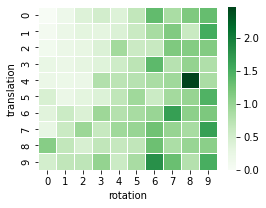

In [15]:

da = np.reshape(np.array(data2),(10,10))
fig = plot_heatmap_2D(da, 'rotation', 'translation')
plt.savefig('mean_distance_error_matrix.pdf', format='pdf', bbox_inches='tight')